In [1]:
import os
import shutil

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
import numpy as np
from sklearn.utils import shuffle
np.random.seed(1)
from keras import backend as K

import h5py
import sys

from PIL import Image
sys.modules['Image'] = Image

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [49]:
# prepare image tensor

image_gen = ImageDataGenerator(preprocessing_function=inception_resnet_v2.preprocess_input)

img_width, img_height = 299,299

train_gen = image_gen.flow_from_directory("train2", (img_width,img_height), shuffle=False,
                                    batch_size=4, class_mode=None)


test_gen = image_gen.flow_from_directory("test", (img_width,img_height), shuffle=False, 
                                         batch_size=8, class_mode=None)



train_filenames = train_gen.filenames
train_nb_samples = len(train_filenames)//8

test_filenames = test_gen.filenames
test_nb_samples = len(test_filenames)//8

preprocess_input = inception_resnet_v2.preprocess_input

# define professor X
x = Input((299, 299, 3))
#x = Lambda(preprocess_input)(x)
x = InceptionResNetV2(input_tensor=x, weights='imagenet', include_top=False, pooling = 'avg')


train = x.predict_generator(train_gen, steps=train_nb_samples, verbose=1)

test = x.predict_generator(test_gen, steps=test_nb_samples, verbose=1)
    

Found 24992 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
1562/1562 [==============================] - 432s 276ms/step


In [17]:
#batch size 16
print(len(train[0])*len(train))

38387712


In [40]:
#batch size 20
print(len(train[0])*len(train))

38369280


In [50]:
#batch size 8
print(len(train[0])*len(train))

38387712


In [52]:
with h5py.File("gap_inception_resnet_v2_weights_v3.h5") as h:
    h.create_dataset("train", data=train)
    h.create_dataset("test", data=test)
    h.create_dataset("label", data=train_gen.classes)


In [54]:
for filename in ["gap_inception_resnet_v2_weights_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        print(len(np.array(h['train'])),len(np.array(h['train'])[0]))
        print(len(np.array(h['label'])))

for filename in ["gap_inception_resnet_v2_weights_v2.h5"]:
    with h5py.File(filename, 'r') as h:
        print(len(np.array(h['train'])),len(np.array(h['train'])[0]))
        print(len(np.array(h['label'])))

24992 1536
24992
24980 1536
24992


In [55]:
X_train = []
X_test = []

for filename in ["gap_inception_resnet_v2_weights_v3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])
 
X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

In [30]:
print(len(X_train)*len(X_train[0]))

38387712


In [56]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

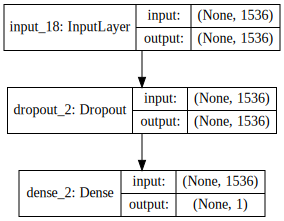

In [57]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [33]:
model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 19993 samples, validate on 4999 samples
Epoch 1/8
19993/19993 [==============================] - 52s 3ms/step - loss: 0.1179 - acc: 0.9755 - val_loss: 0.0428 - val_acc: 0.9922
Epoch 2/8
19993/19993 [==============================] - 2s 92us/step - loss: 0.0334 - acc: 0.9930 - val_loss: 0.0307 - val_acc: 0.9928
Epoch 3/8
19993/19993 [==============================] - 2s 92us/step - loss: 0.0254 - acc: 0.9933 - val_loss: 0.0274 - val_acc: 0.9926
Epoch 4/8
19993/19993 [==============================] - 2s 92us/step - loss: 0.0236 - acc: 0.9939 - val_loss: 0.0257 - val_acc: 0.9932
Epoch 5/8
19993/19993 [==============================] - 2s 94us/step - loss: 0.0215 - acc: 0.9943 - val_loss: 0.0246 - val_acc: 0.9932
Epoch 6/8
19993/19993 [==============================] - 2s 93us/step - loss: 0.0186 - acc: 0.9949 - val_loss: 0.0259 - val_acc: 0.9930
Epoch 7/8
19993/19993 [==============================] - 2s 92us/step - loss: 0.0192 - acc: 0.9948 - val_loss: 0.0260 - val_acc: 0.9928

In [58]:
model.fit(X_train, y_train, batch_size=8, nb_epoch=8, validation_split=0.2)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 19993 samples, validate on 4999 samples
Epoch 1/8
19993/19993 [==============================] - 88s 4ms/step - loss: 0.0427 - acc: 0.9903 - val_loss: 0.0190 - val_acc: 0.9948
Epoch 2/8
19993/19993 [==============================] - 32s 2ms/step - loss: 0.0257 - acc: 0.9934 - val_loss: 0.0185 - val_acc: 0.9948
Epoch 3/8
19993/19993 [==============================] - 33s 2ms/step - loss: 0.0253 - acc: 0.9942 - val_loss: 0.0182 - val_acc: 0.9948
Epoch 4/8
19993/19993 [==============================] - 33s 2ms/step - loss: 0.0251 - acc: 0.9943 - val_loss: 0.0174 - val_acc: 0.9952
Epoch 5/8
19993/19993 [==============================] - 33s 2ms/step - loss: 0.0251 - acc: 0.9943 - val_loss: 0.0198 - val_acc: 0.9948
Epoch 6/8
19993/19993 [==============================] - 33s 2ms/step - loss: 0.0245 - acc: 0.9947 - val_loss: 0.0178 - val_acc: 0.9952
Epoch 7/8
19993/19993 [==============================] - 33s 2ms/step - loss: 0.0246 - acc: 0.9948 - val_loss: 0.0181 - val_acc: 0.9950

In [59]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")


for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    print(y_pred[i],index)
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('test_result_save_weights_v1.csv', index=None)
df.head(10)

12496/12496 [==============================] - 28s 2ms/step
[0.995] 1
[0.005] 10
[0.005] 100
[0.995] 1000
[0.995] 10000
[0.005] 10001
[0.005] 10002
[0.995] 10003
[0.995] 10004
[0.005] 10005
[0.005] 10006
[0.005] 10007
[0.005] 10008
[0.005] 10009
[0.005] 1001
[0.995] 10010
[0.995] 10011
[0.005] 10012
[0.005] 10013
[0.005] 10014
[0.995] 10015
[0.005] 10016
[0.005] 10017
[0.005] 10018
[0.005] 10019
[0.995] 1002
[0.005] 10020
[0.005] 10021
[0.995] 10022
[0.995] 10023
[0.995] 10024
[0.995] 10025
[0.995] 10026
[0.995] 10027
[0.005] 10028
[0.9948881] 10029
[0.995] 1003
[0.995] 10030
[0.005] 10031
[0.005] 10032
[0.005] 10033
[0.995] 10034
[0.995] 10035
[0.995] 10036
[0.17603637] 10037
[0.995] 10038
[0.995] 10039
[0.995] 1004
[0.005] 10040
[0.995] 10041
[0.995] 10042
[0.995] 10043
[0.005] 10044
[0.995] 10045
[0.995] 10046
[0.995] 10047
[0.995] 10048
[0.005] 10049
[0.005] 1005
[0.005] 10050
[0.005] 10051
[0.005] 10052
[0.995] 10053
[0.005] 10054
[0.005] 10055
[0.995] 10056
[0.005] 10057
[0.995] 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


10296
[0.995] 10297
[0.995] 10298
[0.005] 10299
[0.005] 103
[0.005] 1030
[0.995] 10300
[0.005] 10301
[0.995] 10302
[0.005] 10303
[0.995] 10304
[0.995] 10305
[0.995] 10306
[0.995] 10307
[0.005] 10308
[0.005] 10309
[0.005] 1031
[0.39121127] 10310
[0.005] 10311
[0.005] 10312
[0.995] 10313
[0.005] 10314
[0.995] 10315
[0.995] 10316
[0.995] 10317
[0.005] 10318
[0.995] 10319
[0.995] 1032
[0.995] 10320
[0.995] 10321
[0.995] 10322
[0.995] 10323
[0.995] 10324
[0.005] 10325
[0.995] 10326
[0.995] 10327
[0.005] 10328
[0.995] 10329
[0.97500336] 1033
[0.005] 10330
[0.005] 10331
[0.995] 10332
[0.005] 10333
[0.005] 10334
[0.995] 10335
[0.005] 10336
[0.005] 10337
[0.005] 10338
[0.995] 10339
[0.995] 1034
[0.005] 10340
[0.005] 10341
[0.995] 10342
[0.005] 10343
[0.995] 10344
[0.995] 10345
[0.005] 10346
[0.005] 10347
[0.995] 10348
[0.995] 10349
[0.005] 1035
[0.995] 10350
[0.005] 10351
[0.995] 10352
[0.01037065] 10353
[0.9939844] 10354
[0.995] 10355
[0.005] 10356
[0.995] 10357
[0.005] 10358
[0.995] 10359
[0.

[0.995] 10866
[0.005] 10867
[0.11993062] 10868
[0.995] 10869
[0.995] 1087
[0.005] 10870
[0.005] 10871
[0.995] 10872
[0.005] 10873
[0.005] 10874
[0.995] 10875
[0.995] 10876
[0.005] 10877
[0.005] 10878
[0.995] 10879
[0.0306013] 1088
[0.005] 10880
[0.995] 10881
[0.995] 10882
[0.995] 10883
[0.005] 10884
[0.005] 10885
[0.005] 10886
[0.005] 10887
[0.995] 10888
[0.005] 10889
[0.995] 1089
[0.005] 10890
[0.005] 10891
[0.995] 10892
[0.005] 10893
[0.005] 10894
[0.995] 10895
[0.995] 10896
[0.995] 10897
[0.995] 10898
[0.995] 10899
[0.9909025] 109
[0.005] 1090
[0.995] 10900
[0.005] 10901
[0.995] 10902
[0.995] 10903
[0.995] 10904
[0.995] 10905
[0.005] 10906
[0.995] 10907
[0.005] 10908
[0.995] 10909
[0.99494076] 1091
[0.005] 10910
[0.995] 10911
[0.995] 10912
[0.005] 10913
[0.995] 10914
[0.005] 10915
[0.995] 10916
[0.005] 10917
[0.005] 10918
[0.995] 10919
[0.005] 1092
[0.995] 10920
[0.005] 10921
[0.005] 10922
[0.005] 10923
[0.995] 10924
[0.995] 10925
[0.995] 10926
[0.005] 10927
[0.005] 10928
[0.995] 10

[0.005] 11457
[0.995] 11458
[0.995] 11459
[0.995] 1146
[0.005] 11460
[0.995] 11461
[0.005] 11462
[0.005] 11463
[0.995] 11464
[0.005] 11465
[0.005] 11466
[0.005] 11467
[0.995] 11468
[0.995] 11469
[0.995] 1147
[0.995] 11470
[0.005] 11471
[0.995] 11472
[0.995] 11473
[0.005] 11474
[0.005] 11475
[0.005] 11476
[0.005] 11477
[0.995] 11478
[0.005] 11479
[0.005] 1148
[0.005] 11480
[0.005] 11481
[0.995] 11482
[0.995] 11483
[0.005] 11484
[0.005] 11485
[0.995] 11486
[0.995] 11487
[0.995] 11488
[0.005] 11489
[0.995] 1149
[0.995] 11490
[0.005] 11491
[0.005] 11492
[0.005] 11493
[0.9928912] 11494
[0.005] 11495
[0.995] 11496
[0.995] 11497
[0.005] 11498
[0.005] 11499
[0.005] 115
[0.005] 1150
[0.005] 11500
[0.005] 11501
[0.995] 11502
[0.995] 11503
[0.005] 11504
[0.005] 11505
[0.995] 11506
[0.97770214] 11507
[0.005] 11508
[0.005] 11509
[0.995] 1151
[0.995] 11510
[0.005] 11511
[0.995] 11512
[0.995] 11513
[0.995] 11514
[0.995] 11515
[0.995] 11516
[0.005] 11517
[0.005] 11518
[0.995] 11519
[0.005] 1152
[0.995

[0.005] 11996
[0.995] 11997
[0.995] 11998
[0.995] 11999
[0.995] 12
[0.005] 120
[0.995] 1200
[0.005] 12000
[0.995] 12001
[0.005] 12002
[0.005] 12003
[0.005] 12004
[0.995] 12005
[0.995] 12006
[0.005] 12007
[0.005] 12008
[0.995] 12009
[0.995] 1201
[0.995] 12010
[0.995] 12011
[0.995] 12012
[0.995] 12013
[0.995] 12014
[0.995] 12015
[0.005] 12016
[0.995] 12017
[0.005] 12018
[0.005] 12019
[0.005] 1202
[0.005] 12020
[0.995] 12021
[0.995] 12022
[0.995] 12023
[0.995] 12024
[0.005] 12025
[0.995] 12026
[0.005] 12027
[0.995] 12028
[0.005] 12029
[0.995] 1203
[0.005] 12030
[0.005] 12031
[0.005] 12032
[0.995] 12033
[0.005] 12034
[0.995] 12035
[0.005] 12036
[0.995] 12037
[0.995] 12038
[0.995] 12039
[0.005] 1204
[0.995] 12040
[0.99252594] 12041
[0.005] 12042
[0.005] 12043
[0.005] 12044
[0.005] 12045
[0.995] 12046
[0.005] 12047
[0.995] 12048
[0.005] 12049
[0.995] 1205
[0.005] 12050
[0.995] 12051
[0.995] 12052
[0.005] 12053
[0.995] 12054
[0.9919085] 12055
[0.995] 12056
[0.995] 12057
[0.005] 12058
[0.005] 

[0.005] 1336
[0.005] 1337
[0.005] 1338
[0.005] 1339
[0.005] 134
[0.995] 1340
[0.005] 1341
[0.995] 1342
[0.995] 1343
[0.005] 1344
[0.005] 1345
[0.005] 1346
[0.005] 1347
[0.005] 1348
[0.005] 1349
[0.005] 135
[0.995] 1350
[0.995] 1351
[0.005] 1352
[0.995] 1353
[0.005] 1354
[0.005] 1355
[0.995] 1356
[0.005] 1357
[0.995] 1358
[0.005] 1359
[0.005] 136
[0.995] 1360
[0.005] 1361
[0.005] 1362
[0.005] 1363
[0.005] 1364
[0.005] 1365
[0.995] 1366
[0.9188042] 1367
[0.005] 1368
[0.995] 1369
[0.995] 137
[0.005] 1370
[0.005] 1371
[0.995] 1372
[0.995] 1373
[0.005] 1374
[0.005] 1375
[0.995] 1376
[0.995] 1377
[0.995] 1378
[0.005] 1379
[0.995] 138
[0.005] 1380
[0.995] 1381
[0.995] 1382
[0.005] 1383
[0.995] 1384
[0.995] 1385
[0.995] 1386
[0.995] 1387
[0.005] 1388
[0.995] 1389
[0.005] 139
[0.005] 1390
[0.005] 1391
[0.005] 1392
[0.995] 1393
[0.005] 1394
[0.995] 1395
[0.005] 1396
[0.005] 1397
[0.005] 1398
[0.995] 1399
[0.005] 14
[0.005] 140
[0.995] 1400
[0.995] 1401
[0.995] 1402
[0.005] 1403
[0.005] 1404
[0.9

[0.005] 1926
[0.005] 1927
[0.995] 1928
[0.005] 1929
[0.005] 193
[0.995] 1930
[0.005] 1931
[0.995] 1932
[0.995] 1933
[0.005] 1934
[0.005] 1935
[0.005] 1936
[0.995] 1937
[0.995] 1938
[0.995] 1939
[0.005] 194
[0.995] 1940
[0.995] 1941
[0.005] 1942
[0.96359444] 1943
[0.005] 1944
[0.005] 1945
[0.005] 1946
[0.995] 1947
[0.995] 1948
[0.995] 1949
[0.995] 195
[0.995] 1950
[0.005] 1951
[0.005] 1952
[0.005] 1953
[0.995] 1954
[0.005] 1955
[0.995] 1956
[0.005] 1957
[0.005] 1958
[0.005] 1959
[0.995] 196
[0.005] 1960
[0.005] 1961
[0.995] 1962
[0.005] 1963
[0.005] 1964
[0.005] 1965
[0.995] 1966
[0.005] 1967
[0.995] 1968
[0.005] 1969
[0.995] 197
[0.995] 1970
[0.005] 1971
[0.98965] 1972
[0.005] 1973
[0.005] 1974
[0.005] 1975
[0.005] 1976
[0.995] 1977
[0.005] 1978
[0.995] 1979
[0.005] 198
[0.995] 1980
[0.995] 1981
[0.005] 1982
[0.995] 1983
[0.995] 1984
[0.005] 1985
[0.995] 1986
[0.995] 1987
[0.005] 1988
[0.995] 1989
[0.995] 199
[0.995] 1990
[0.995] 1991
[0.005] 1992
[0.005] 1993
[0.995] 1994
[0.005] 1995

[0.995] 2527
[0.005] 2528
[0.995] 2529
[0.995] 253
[0.005] 2530
[0.005] 2531
[0.995] 2532
[0.995] 2533
[0.005] 2534
[0.005] 2535
[0.005] 2536
[0.995] 2537
[0.005] 2538
[0.995] 2539
[0.005] 254
[0.005] 2540
[0.995] 2541
[0.005] 2542
[0.995] 2543
[0.9819902] 2544
[0.005] 2545
[0.995] 2546
[0.995] 2547
[0.005] 2548
[0.005] 2549
[0.005] 255
[0.005] 2550
[0.005] 2551
[0.995] 2552
[0.005] 2553
[0.005] 2554
[0.995] 2555
[0.995] 2556
[0.005] 2557
[0.005] 2558
[0.995] 2559
[0.005] 256
[0.995] 2560
[0.995] 2561
[0.995] 2562
[0.005] 2563
[0.005] 2564
[0.005] 2565
[0.995] 2566
[0.005] 2567
[0.995] 2568
[0.995] 2569
[0.995] 257
[0.995] 2570
[0.005] 2571
[0.005] 2572
[0.995] 2573
[0.005] 2574
[0.995] 2575
[0.005] 2576
[0.995] 2577
[0.005] 2578
[0.995] 2579
[0.995] 258
[0.005] 2580
[0.995] 2581
[0.995] 2582
[0.995] 2583
[0.005] 2584
[0.005] 2585
[0.005] 2586
[0.005] 2587
[0.005] 2588
[0.995] 2589
[0.005] 259
[0.995] 2590
[0.005] 2591
[0.005] 2592
[0.005] 2593
[0.995] 2594
[0.005] 2595
[0.005] 2596
[0

[0.005] 3111
[0.995] 3112
[0.005] 3113
[0.995] 3114
[0.995] 3115
[0.995] 3116
[0.995] 3117
[0.005] 3118
[0.995] 3119
[0.005] 312
[0.995] 3120
[0.005] 3121
[0.005] 3122
[0.005] 3123
[0.995] 3124
[0.995] 3125
[0.005] 3126
[0.005] 3127
[0.995] 3128
[0.995] 3129
[0.005] 313
[0.005] 3130
[0.005] 3131
[0.005] 3132
[0.995] 3133
[0.995] 3134
[0.005] 3135
[0.995] 3136
[0.995] 3137
[0.995] 3138
[0.995] 3139
[0.005] 314
[0.96968037] 3140
[0.995] 3141
[0.005] 3142
[0.995] 3143
[0.005] 3144
[0.995] 3145
[0.005] 3146
[0.995] 3147
[0.995] 3148
[0.995] 3149
[0.995] 315
[0.98967254] 3150
[0.995] 3151
[0.995] 3152
[0.005] 3153
[0.005] 3154
[0.995] 3155
[0.995] 3156
[0.995] 3157
[0.005] 3158
[0.9943023] 3159
[0.005] 316
[0.9939996] 3160
[0.005] 3161
[0.995] 3162
[0.005] 3163
[0.005] 3164
[0.005] 3165
[0.995] 3166
[0.005] 3167
[0.005] 3168
[0.005] 3169
[0.995] 317
[0.995] 3170
[0.005] 3171
[0.005] 3172
[0.005] 3173
[0.005] 3174
[0.005] 3175
[0.995] 3176
[0.005] 3177
[0.995] 3178
[0.005] 3179
[0.005] 318
[

[0.005] 3702
[0.005] 3703
[0.005] 3704
[0.005] 3705
[0.995] 3706
[0.995] 3707
[0.995] 3708
[0.005] 3709
[0.995] 371
[0.995] 3710
[0.005] 3711
[0.005] 3712
[0.995] 3713
[0.005] 3714
[0.995] 3715
[0.995] 3716
[0.995] 3717
[0.995] 3718
[0.995] 3719
[0.005] 372
[0.005] 3720
[0.005] 3721
[0.995] 3722
[0.005] 3723
[0.005] 3724
[0.005] 3725
[0.005] 3726
[0.005] 3727
[0.005] 3728
[0.005] 3729
[0.995] 373
[0.005] 3730
[0.005] 3731
[0.005] 3732
[0.005] 3733
[0.995] 3734
[0.99019605] 3735
[0.995] 3736
[0.005] 3737
[0.005] 3738
[0.995] 3739
[0.005] 374
[0.005] 3740
[0.995] 3741
[0.995] 3742
[0.005] 3743
[0.995] 3744
[0.005] 3745
[0.005] 3746
[0.005] 3747
[0.005] 3748
[0.995] 3749
[0.995] 375
[0.995] 3750
[0.995] 3751
[0.995] 3752
[0.005] 3753
[0.995] 3754
[0.995] 3755
[0.995] 3756
[0.995] 3757
[0.995] 3758
[0.005] 3759
[0.005] 376
[0.005] 3760
[0.995] 3761
[0.005] 3762
[0.005] 3763
[0.005] 3764
[0.995] 3765
[0.005] 3766
[0.005] 3767
[0.995] 3768
[0.005] 3769
[0.995] 377
[0.995] 3770
[0.995] 3771
[

[0.995] 4295
[0.005] 4296
[0.995] 4297
[0.005] 4298
[0.995] 4299
[0.995] 43
[0.995] 430
[0.995] 4300
[0.005] 4301
[0.995] 4302
[0.995] 4303
[0.995] 4304
[0.00700034] 4305
[0.005] 4306
[0.995] 4307
[0.005] 4308
[0.995] 4309
[0.995] 431
[0.005] 4310
[0.005] 4311
[0.005] 4312
[0.005] 4313
[0.995] 4314
[0.995] 4315
[0.995] 4316
[0.995] 4317
[0.005] 4318
[0.995] 4319
[0.005] 432
[0.005] 4320
[0.995] 4321
[0.995] 4322
[0.005] 4323
[0.005] 4324
[0.995] 4325
[0.005] 4326
[0.995] 4327
[0.995] 4328
[0.005] 4329
[0.995] 433
[0.995] 4330
[0.005] 4331
[0.005] 4332
[0.995] 4333
[0.995] 4334
[0.995] 4335
[0.995] 4336
[0.005] 4337
[0.995] 4338
[0.005] 4339
[0.995] 434
[0.995] 4340
[0.995] 4341
[0.9929137] 4342
[0.995] 4343
[0.995] 4344
[0.005] 4345
[0.005] 4346
[0.995] 4347
[0.005] 4348
[0.995] 4349
[0.995] 435
[0.99331963] 4350
[0.995] 4351
[0.995] 4352
[0.995] 4353
[0.995] 4354
[0.005] 4355
[0.005] 4356
[0.995] 4357
[0.995] 4358
[0.005] 4359
[0.005] 436
[0.995] 4360
[0.005] 4361
[0.995] 4362
[0.005]

[0.995] 489
[0.995] 4890
[0.005] 4891
[0.005] 4892
[0.005] 4893
[0.995] 4894
[0.995] 4895
[0.005] 4896
[0.995] 4897
[0.995] 4898
[0.005] 4899
[0.995] 49
[0.995] 490
[0.005] 4900
[0.995] 4901
[0.995] 4902
[0.005] 4903
[0.005] 4904
[0.005] 4905
[0.005] 4906
[0.005] 4907
[0.995] 4908
[0.995] 4909
[0.995] 491
[0.005] 4910
[0.995] 4911
[0.995] 4912
[0.995] 4913
[0.005] 4914
[0.995] 4915
[0.005] 4916
[0.005] 4917
[0.87593895] 4918
[0.9913573] 4919
[0.005] 492
[0.005] 4920
[0.005] 4921
[0.005] 4922
[0.005] 4923
[0.995] 4924
[0.005] 4925
[0.995] 4926
[0.995] 4927
[0.005] 4928
[0.995] 4929
[0.005] 493
[0.005] 4930
[0.995] 4931
[0.005] 4932
[0.005] 4933
[0.005] 4934
[0.995] 4935
[0.005] 4936
[0.995] 4937
[0.995] 4938
[0.995] 4939
[0.005] 494
[0.995] 4940
[0.995] 4941
[0.995] 4942
[0.005] 4943
[0.005] 4944
[0.005] 4945
[0.995] 4946
[0.005] 4947
[0.005] 4948
[0.005] 4949
[0.995] 495
[0.995] 4950
[0.005] 4951
[0.995] 4952
[0.995] 4953
[0.995] 4954
[0.995] 4955
[0.005] 4956
[0.005] 4957
[0.005] 4958

[0.005] 549
[0.995] 5490
[0.995] 5491
[0.9046402] 5492
[0.995] 5493
[0.995] 5494
[0.995] 5495
[0.995] 5496
[0.9931677] 5497
[0.005] 5498
[0.005] 5499
[0.005] 55
[0.005] 550
[0.005] 5500
[0.995] 5501
[0.005] 5502
[0.995] 5503
[0.995] 5504
[0.995] 5505
[0.005] 5506
[0.995] 5507
[0.995] 5508
[0.995] 5509
[0.005] 551
[0.995] 5510
[0.995] 5511
[0.995] 5512
[0.995] 5513
[0.995] 5514
[0.995] 5515
[0.995] 5516
[0.005] 5517
[0.005] 5518
[0.995] 5519
[0.995] 552
[0.995] 5520
[0.995] 5521
[0.995] 5522
[0.005] 5523
[0.995] 5524
[0.005] 5525
[0.995] 5526
[0.995] 5527
[0.995] 5528
[0.005] 5529
[0.005] 553
[0.005] 5530
[0.995] 5531
[0.995] 5532
[0.005] 5533
[0.995] 5534
[0.005] 5535
[0.995] 5536
[0.005] 5537
[0.005] 5538
[0.995] 5539
[0.005] 554
[0.005] 5540
[0.005] 5541
[0.005] 5542
[0.99197525] 5543
[0.005] 5544
[0.005] 5545
[0.005] 5546
[0.005] 5547
[0.995] 5548
[0.005] 5549
[0.995] 555
[0.995] 5550
[0.91995484] 5551
[0.005] 5552
[0.005] 5553
[0.995] 5554
[0.995] 5555
[0.005] 5556
[0.005] 5557
[0.

[0.005] 6083
[0.995] 6084
[0.995] 6085
[0.995] 6086
[0.995] 6087
[0.995] 6088
[0.995] 6089
[0.005] 609
[0.995] 6090
[0.995] 6091
[0.005] 6092
[0.995] 6093
[0.995] 6094
[0.005] 6095
[0.005] 6096
[0.005] 6097
[0.005] 6098
[0.005] 6099
[0.005] 61
[0.995] 610
[0.005] 6100
[0.005] 6101
[0.005] 6102
[0.9879346] 6103
[0.995] 6104
[0.995] 6105
[0.995] 6106
[0.995] 6107
[0.995] 6108
[0.995] 6109
[0.005] 611
[0.005] 6110
[0.995] 6111
[0.005] 6112
[0.005] 6113
[0.005] 6114
[0.005] 6115
[0.995] 6116
[0.995] 6117
[0.995] 6118
[0.005] 6119
[0.995] 612
[0.995] 6120
[0.995] 6121
[0.005] 6122
[0.995] 6123
[0.005] 6124
[0.995] 6125
[0.995] 6126
[0.005] 6127
[0.995] 6128
[0.005] 6129
[0.005] 613
[0.995] 6130
[0.005] 6131
[0.005] 6132
[0.005] 6133
[0.995] 6134
[0.005] 6135
[0.005] 6136
[0.995] 6137
[0.005] 6138
[0.9915633] 6139
[0.005] 614
[0.995] 6140
[0.995] 6141
[0.995] 6142
[0.005] 6143
[0.005] 6144
[0.005] 6145
[0.005] 6146
[0.005] 6147
[0.995] 6148
[0.005] 6149
[0.005] 615
[0.005] 6150
[0.995] 6151


[0.005] 6682
[0.005] 6683
[0.005] 6684
[0.995] 6685
[0.005] 6686
[0.005] 6687
[0.995] 6688
[0.005] 6689
[0.995] 669
[0.005] 6690
[0.005] 6691
[0.005] 6692
[0.005] 6693
[0.005] 6694
[0.01548913] 6695
[0.005] 6696
[0.005] 6697
[0.005] 6698
[0.995] 6699
[0.995] 67
[0.995] 670
[0.995] 6700
[0.995] 6701
[0.005] 6702
[0.995] 6703
[0.995] 6704
[0.005] 6705
[0.005] 6706
[0.995] 6707
[0.995] 6708
[0.005] 6709
[0.005] 671
[0.995] 6710
[0.005] 6711
[0.995] 6712
[0.005] 6713
[0.005] 6714
[0.995] 6715
[0.995] 6716
[0.005] 6717
[0.995] 6718
[0.9771822] 6719
[0.005] 672
[0.995] 6720
[0.995] 6721
[0.995] 6722
[0.005] 6723
[0.005] 6724
[0.995] 6725
[0.005] 6726
[0.005] 6727
[0.995] 6728
[0.995] 6729
[0.005] 673
[0.005] 6730
[0.995] 6731
[0.995] 6732
[0.995] 6733
[0.995] 6734
[0.995] 6735
[0.005] 6736
[0.995] 6737
[0.995] 6738
[0.005] 6739
[0.005] 674
[0.005] 6740
[0.995] 6741
[0.995] 6742
[0.005] 6743
[0.005] 6744
[0.995] 6745
[0.005] 6746
[0.005] 6747
[0.005] 6748
[0.005] 6749
[0.7237243] 675
[0.005] 

[0.995] 7267
[0.005] 7268
[0.005] 7269
[0.995] 727
[0.005] 7270
[0.995] 7271
[0.005] 7272
[0.005] 7273
[0.9719468] 7274
[0.005] 7275
[0.005] 7276
[0.005] 7277
[0.005] 7278
[0.995] 7279
[0.005] 728
[0.995] 7280
[0.04243086] 7281
[0.005] 7282
[0.995] 7283
[0.005] 7284
[0.995] 7285
[0.005] 7286
[0.005] 7287
[0.005] 7288
[0.005] 7289
[0.005] 729
[0.01545829] 7290
[0.995] 7291
[0.005] 7292
[0.995] 7293
[0.995] 7294
[0.005] 7295
[0.005] 7296
[0.005] 7297
[0.995] 7298
[0.005] 7299
[0.995] 73
[0.995] 730
[0.995] 7300
[0.005] 7301
[0.005] 7302
[0.005] 7303
[0.005] 7304
[0.995] 7305
[0.995] 7306
[0.005] 7307
[0.005] 7308
[0.995] 7309
[0.995] 731
[0.005] 7310
[0.005] 7311
[0.005] 7312
[0.005] 7313
[0.995] 7314
[0.995] 7315
[0.995] 7316
[0.005] 7317
[0.005] 7318
[0.995] 7319
[0.995] 732
[0.005] 7320
[0.995] 7321
[0.005] 7322
[0.995] 7323
[0.005] 7324
[0.005] 7325
[0.995] 7326
[0.9941947] 7327
[0.995] 7328
[0.005] 7329
[0.005] 733
[0.005] 7330
[0.005] 7331
[0.995] 7332
[0.005] 7333
[0.995] 7334
[0.

[0.995] 7873
[0.995] 7874
[0.995] 7875
[0.005] 7876
[0.005] 7877
[0.005] 7878
[0.005] 7879
[0.005] 788
[0.995] 7880
[0.995] 7881
[0.005] 7882
[0.005] 7883
[0.005] 7884
[0.995] 7885
[0.005] 7886
[0.995] 7887
[0.005] 7888
[0.005] 7889
[0.995] 789
[0.005] 7890
[0.9479567] 7891
[0.995] 7892
[0.995] 7893
[0.995] 7894
[0.005] 7895
[0.995] 7896
[0.005] 7897
[0.995] 7898
[0.005] 7899
[0.995] 79
[0.995] 790
[0.995] 7900
[0.995] 7901
[0.995] 7902
[0.995] 7903
[0.005] 7904
[0.005] 7905
[0.995] 7906
[0.995] 7907
[0.9310424] 7908
[0.995] 7909
[0.995] 791
[0.005] 7910
[0.995] 7911
[0.995] 7912
[0.995] 7913
[0.995] 7914
[0.005] 7915
[0.995] 7916
[0.005] 7917
[0.995] 7918
[0.005] 7919
[0.995] 792
[0.995] 7920
[0.9922064] 7921
[0.995] 7922
[0.995] 7923
[0.005] 7924
[0.995] 7925
[0.005] 7926
[0.995] 7927
[0.995] 7928
[0.995] 7929
[0.995] 793
[0.005] 7930
[0.005] 7931
[0.995] 7932
[0.995] 7933
[0.995] 7934
[0.995] 7935
[0.005] 7936
[0.995] 7937
[0.995] 7938
[0.995] 7939
[0.995] 794
[0.005] 7940
[0.995] 7

[0.995] 8479
[0.995] 848
[0.005] 8480
[0.995] 8481
[0.005] 8482
[0.995] 8483
[0.005] 8484
[0.995] 8485
[0.995] 8486
[0.005] 8487
[0.995] 8488
[0.005] 8489
[0.005] 849
[0.005] 8490
[0.005] 8491
[0.005] 8492
[0.005] 8493
[0.005] 8494
[0.005] 8495
[0.995] 8496
[0.995] 8497
[0.005] 8498
[0.005] 8499
[0.995] 85
[0.005] 850
[0.005] 8500
[0.005] 8501
[0.005] 8502
[0.995] 8503
[0.005] 8504
[0.995] 8505
[0.005] 8506
[0.005] 8507
[0.005] 8508
[0.995] 8509
[0.995] 851
[0.01464725] 8510
[0.005] 8511
[0.995] 8512
[0.005] 8513
[0.005] 8514
[0.995] 8515
[0.995] 8516
[0.005] 8517
[0.995] 8518
[0.995] 8519
[0.005] 852
[0.005] 8520
[0.005] 8521
[0.005] 8522
[0.005] 8523
[0.005] 8524
[0.005] 8525
[0.005] 8526
[0.995] 8527
[0.995] 8528
[0.005] 8529
[0.995] 853
[0.005] 8530
[0.005] 8531
[0.995] 8532
[0.005] 8533
[0.995] 8534
[0.005] 8535
[0.005] 8536
[0.005] 8537
[0.005] 8538
[0.995] 8539
[0.995] 854
[0.995] 8540
[0.995] 8541
[0.995] 8542
[0.995] 8543
[0.995] 8544
[0.995] 8545
[0.005] 8546
[0.995] 8547
[0.

[0.995] 9075
[0.995] 9076
[0.005] 9077
[0.005] 9078
[0.005] 9079
[0.995] 908
[0.995] 9080
[0.005] 9081
[0.9942569] 9082
[0.995] 9083
[0.995] 9084
[0.995] 9085
[0.9896052] 9086
[0.005] 9087
[0.005] 9088
[0.005] 9089
[0.005] 909
[0.005] 9090
[0.005] 9091
[0.995] 9092
[0.995] 9093
[0.005] 9094
[0.005] 9095
[0.005] 9096
[0.005] 9097
[0.005] 9098
[0.995] 9099
[0.005] 91
[0.005] 910
[0.005] 9100
[0.995] 9101
[0.995] 9102
[0.005] 9103
[0.005] 9104
[0.995] 9105
[0.995] 9106
[0.005] 9107
[0.995] 9108
[0.005] 9109
[0.005] 911
[0.005] 9110
[0.995] 9111
[0.005] 9112
[0.005] 9113
[0.005] 9114
[0.995] 9115
[0.03294094] 9116
[0.995] 9117
[0.005] 9118
[0.995] 9119
[0.995] 912
[0.005] 9120
[0.005] 9121
[0.005] 9122
[0.005] 9123
[0.005] 9124
[0.005] 9125
[0.995] 9126
[0.005] 9127
[0.995] 9128
[0.995] 9129
[0.995] 913
[0.005] 9130
[0.005] 9131
[0.995] 9132
[0.995] 9133
[0.995] 9134
[0.995] 9135
[0.995] 9136
[0.005] 9137
[0.995] 9138
[0.995] 9139
[0.005] 914
[0.995] 9140
[0.005] 9141
[0.005] 9142
[0.995] 

[0.005] 9658
[0.995] 9659
[0.995] 966
[0.995] 9660
[0.995] 9661
[0.005] 9662
[0.995] 9663
[0.995] 9664
[0.005] 9665
[0.005] 9666
[0.995] 9667
[0.9807834] 9668
[0.995] 9669
[0.005] 967
[0.005] 9670
[0.995] 9671
[0.005] 9672
[0.005] 9673
[0.995] 9674
[0.995] 9675
[0.005] 9676
[0.995] 9677
[0.995] 9678
[0.995] 9679
[0.995] 968
[0.995] 9680
[0.995] 9681
[0.005] 9682
[0.005] 9683
[0.995] 9684
[0.005] 9685
[0.995] 9686
[0.995] 9687
[0.005] 9688
[0.005] 9689
[0.995] 969
[0.995] 9690
[0.32444242] 9691
[0.005] 9692
[0.005] 9693
[0.995] 9694
[0.995] 9695
[0.99453956] 9696
[0.005] 9697
[0.995] 9698
[0.995] 9699
[0.995] 97
[0.995] 970
[0.005] 9700
[0.995] 9701
[0.995] 9702
[0.9901543] 9703
[0.005] 9704
[0.005] 9705
[0.02748518] 9706
[0.995] 9707
[0.995] 9708
[0.005] 9709
[0.995] 971
[0.005] 9710
[0.005] 9711
[0.005] 9712
[0.995] 9713
[0.98333824] 9714
[0.005] 9715
[0.005] 9716
[0.005] 9717
[0.005] 9718
[0.005] 9719
[0.995] 972
[0.005] 9720
[0.005] 9721
[0.005] 9722
[0.995] 9723
[0.005] 9724
[0.005

IndexError: index 12496 is out of bounds for axis 0 with size 12496

In [61]:
print(len(y_pred))

12496
